In [105]:
import tensorflow as tf
from tensorflow import keras

from nn.rolypoly import dataset, model
from physics.hstar import gghzz, c6
from physics.simulation import msq
from physics.hzz import zpair, angles

import os
import json
import numpy as np
import matplotlib.pyplot as plt

import hist

from sklearn.preprocessing import MinMaxScaler

In [106]:
SEED=373485

BASE_SIZE=10000

OUTPUT_DIRS=['jobs/rolypoly/first-tests-1','jobs/rolypoly/first-tests-2','jobs/rolypoly/first-tests-3','jobs/rolypoly/first-tests-4']
CONF_FILE='rolypoly-config.json'
SCALER_CONF='scaler.json'
SAMPLE_DIR='..'

In [107]:
configs = []

for output_dir in OUTPUT_DIRS:
    with open(os.path.join(output_dir, CONF_FILE), 'r') as conf_file:
        configs.append(json.load(conf_file))

In [108]:
sample_train = gghzz.Process(msq.Component.SIG, (1.5, os.path.join(SAMPLE_DIR, 'ggZZ2e2m_sbi.csv'), 1.2*BASE_SIZE))
sample_val = gghzz.Process(msq.Component.SIG, (1.5, os.path.join(SAMPLE_DIR, 'ggZZ2e2m_sbi.csv'), configs[0]['num_events'] + 1.2*BASE_SIZE))
sample_val.events = sample_val.events[configs[0]['num_events']:]

In [109]:
z_chooser = zpair.ZPairChooser(bounds1=(70,115), bounds2=(70,115), algorithm='leastsquare')
kin_vars_train = angles.calculate_2(*sample_train.events.filter(z_chooser))
kin_vars_val = angles.calculate_2(*sample_val.events.filter(z_chooser))

sample_train.events = sample_train.events[:BASE_SIZE]
kin_vars_train = kin_vars_train[:BASE_SIZE]
sample_val.events = sample_val.events[:BASE_SIZE]
kin_vars_val = kin_vars_val[:BASE_SIZE]

In [110]:
c6_mod_train = c6.Modifier(baseline = msq.Component.SBI, sample=sample_train, c6_values = [-5,-1,0,1,5])
coeff_train = c6_mod_train.coefficients

c6_mod_val = c6.Modifier(baseline = msq.Component.SBI, sample=sample_train, c6_values = [-5,-1,0,1,5])
coeff_val = c6_mod_val.coefficients

In [268]:
print(coeff_train, coeff_train.shape)

[[ 1.00000000e+00 -1.63024450e-04  7.27142001e-05 -8.60880696e-08
   2.14341724e-08]
 [ 1.00000000e+00 -2.75154497e-04  1.25520681e-04 -6.32968769e-07
   1.38488469e-07]
 [ 1.00000000e+00 -2.04067610e-04  2.91070524e-04 -2.25023502e-06
   4.41404127e-07]
 ...
 [ 1.00000000e+00 -3.92686037e-04  2.16428874e-04 -2.00907321e-06
   3.75482129e-07]
 [ 1.00000000e+00 -1.49630153e-04  7.09045640e-05 -1.89266554e-07
   2.05868884e-08]
 [ 1.00000000e+00 -7.06399164e-05  1.09846253e-04 -7.02615848e-07
   1.12194891e-07]] (10000, 5)


In [112]:
train_sets = [dataset.build_dataset(x_arr=kin_vars_train, target=coeff_train[:,i]) for i in range(1,coeff_train.shape[1])]
val_sets = [dataset.build_dataset(x_arr=kin_vars_val, target=coeff_val[:,i]) for i in range(1,coeff_val.shape[1])]

In [113]:
scaler_configs = []

for output_dir in OUTPUT_DIRS:
    with open(os.path.join(output_dir, SCALER_CONF), 'r') as conf_file:
        scaler_configs.append(json.load(conf_file))

In [114]:
scalers = [MinMaxScaler() for _ in range(len(scaler_configs))]
for i in range(len(scalers)):
    scalers[i].min_ = scaler_configs[i]['scaler.min_']
    scalers[i].scale_ = scaler_configs[i]['scaler.scale_']

train_sets = [tf.concat([scalers[i].transform(train_sets[i][:,:9]), train_sets[i][:,9:]], axis=1) for i in range(len(scalers))]
val_sets = [tf.concat([scalers[i].transform(val_sets[i][:,:9]), val_sets[i][:,9:]], axis=1) for i in range(len(scalers))]

In [115]:
rolypoly_models = [model.load(os.path.join(OUTPUT_DIRS[i], 'checkpoint.model.tf')) for i in range(len(OUTPUT_DIRS))]

In [116]:
predictions_train = [rolypoly_models[i].predict(train_sets[i][:,:9]) for i in range(len(OUTPUT_DIRS))]
predictions_val = [rolypoly_models[i].predict(val_sets[i][:,:9]) for i in range(len(OUTPUT_DIRS))]

313/313 [==============================] - 7s 24ms/step


In [117]:
print(tf.reduce_min(train_sets[0][:,-1]))

tf.Tensor(-0.010252721, shape=(), dtype=float32)


In [318]:
def generate_histograms(data_train, pred_train, data_val, pred_val, num_bins, range=(0,1)):
    range_min = tf.minimum(tf.minimum(tf.reduce_min(data_train[:,-1]), tf.reduce_min(pred_train)), tf.reduce_min(pred_val))
    range_max = tf.maximum(tf.maximum(tf.reduce_max(data_train[:,-1]), tf.reduce_max(pred_train)), tf.reduce_max(pred_val))
    hist_true = hist.Hist(hist.axis.Regular(num_bins, range_min, range_max, name='x', label='NN output []'))
    hist_true.fill(data_train[:,-1])

    hist_train = hist.Hist(hist.axis.Regular(num_bins, range_min, range_max, name='x', label='NN output []'))
    hist_train.fill(tf.squeeze(pred_train, axis=1))

    hist_val = hist.Hist(hist.axis.Regular(num_bins, range_min, range_max, name='x', label='NN output []'))
    hist_val.fill(tf.squeeze(pred_val, axis=1))

    return (hist_true.to_numpy(), hist_train.to_numpy(), hist_val.to_numpy())

In [319]:
def plot_histograms(histograms, color='r', xlim=(0.2,0.8), factor=1):
    fig = plt.figure(figsize=(7,6))

    plt.step(histograms[0][1][1:], histograms[0][0], color=color, linestyle='--', label=f'truth', alpha=0.6)
    plt.step(histograms[1][1][1:], histograms[1][0], color=color, label=f'training data', alpha=0.6)
    plt.scatter(histograms[2][1][1:]-factor/len(histograms[2][1][1:]), histograms[2][0], s=20, color=color, label=f'validation data', alpha=0.6)

    plt.xlabel('NN output []')
    plt.ylabel('Percentage of predictions []')
    plt.legend()
    plt.xlim(xlim[0],xlim[1])
    #plt.yscale('log')
    #plt.xscale('log')

    plt.show()

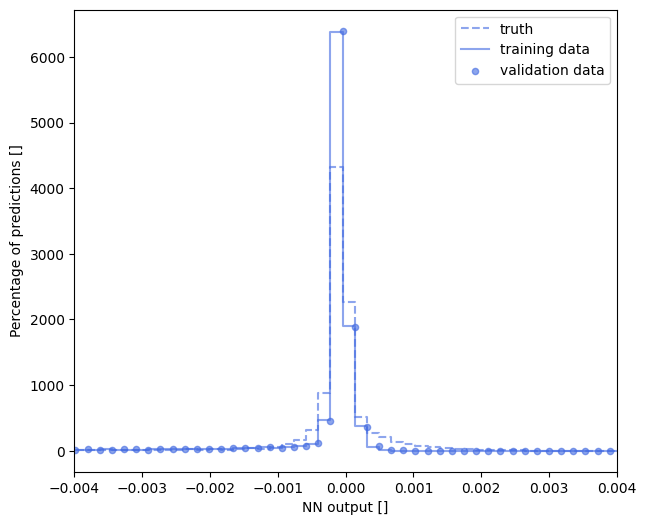

In [320]:
BINS = 80

coeff_index = 1

histograms_1 = generate_histograms(train_sets[0], predictions_train[0], val_sets[0], predictions_val[0], BINS, range=(0,5e-4))
histograms_2 = generate_histograms(train_sets[1], predictions_train[1], val_sets[1], predictions_val[1], BINS, range=(0,2e-2))
histograms_3 = generate_histograms(train_sets[2], predictions_train[2], val_sets[2], predictions_val[2], BINS, range=(0,2e-2))
histograms_4 = generate_histograms(train_sets[3], predictions_train[3], val_sets[3], predictions_val[3], BINS, range=(0,2e-2))

plot_histograms(histograms_1, color='royalblue', xlim=(-4e-3,4e-3), factor=0)#8e-3)

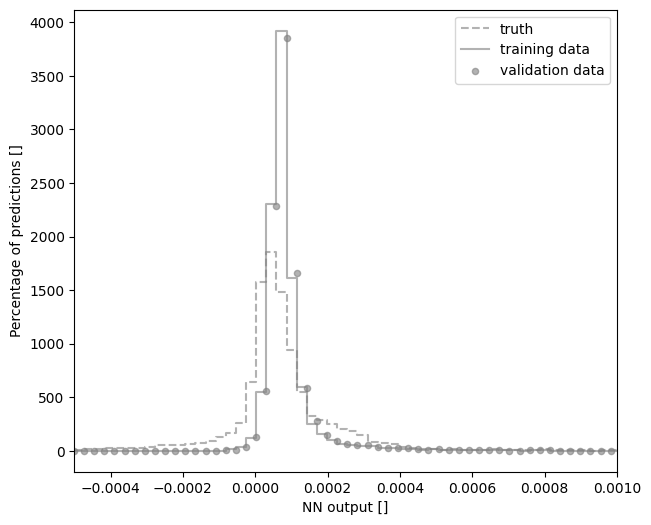

In [321]:
plot_histograms(histograms_2, color='gray', xlim=(-5e-4,1e-3), factor=0)#-9e-4)

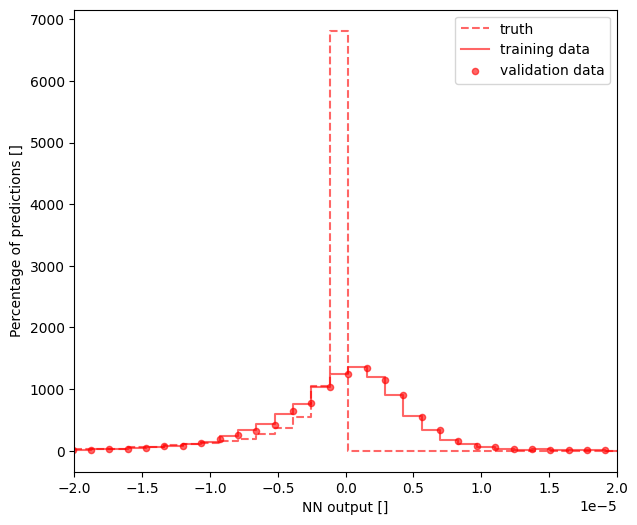

In [322]:
plot_histograms(histograms_3, color='red', xlim=(-2e-5,2e-5), factor=0)#-5.5e-5)

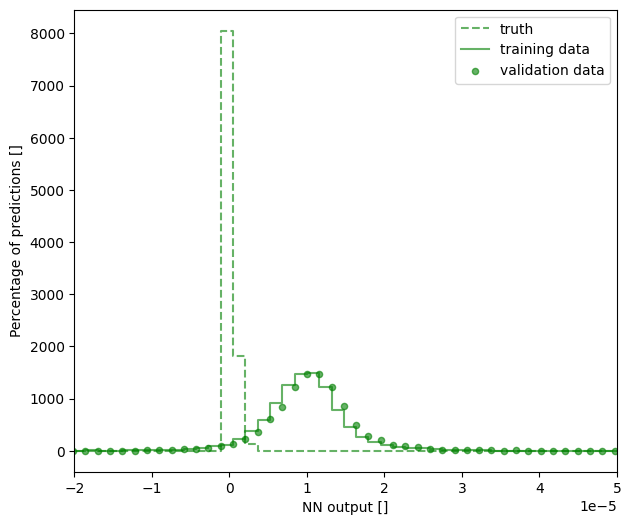

In [323]:
plot_histograms(histograms_4, color='green', xlim=(-2e-5,5e-5), factor=0)#-5.5e-10)

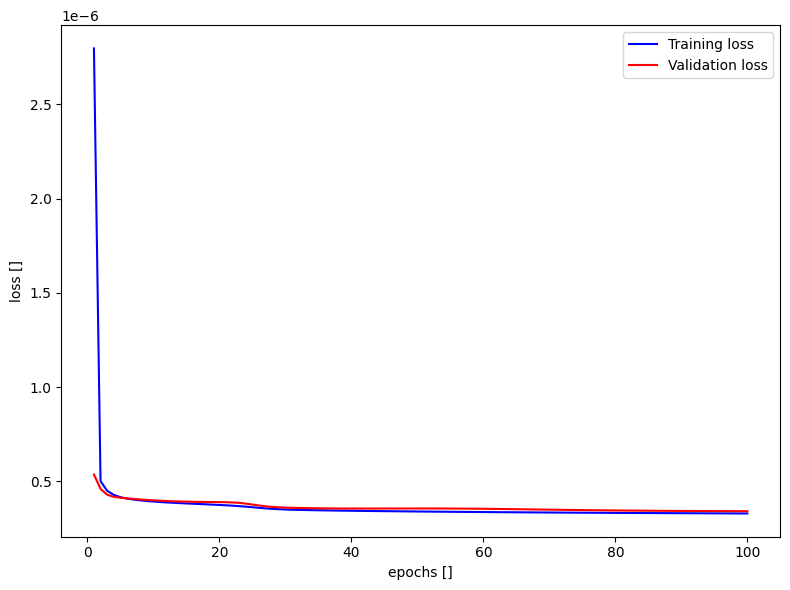

In [219]:
hist_prm = ''

i=0

with open(os.path.join(OUTPUT_DIRS[i], 'history.txt'), 'r') as hist_file:
    hist_prm = hist_file.readlines()

hist_prm = [ np.array(el.replace('[','').replace(']','').replace(' ','').split(','), dtype=float) for el in hist_prm[0].split('][')]

t_loss_prm = np.array(hist_prm[0])
v_loss_prm = np.array(hist_prm[1])

epochs = range(1,t_loss_prm.shape[0]+1)

fig = plt.figure(figsize=(8,6))

#ax1.set_xticklabels([])

plt.plot(epochs, t_loss_prm, 'b', label='Training loss')
plt.xlabel('epochs []')
plt.ylabel(f'loss []')
#ax2.legend()

plt.plot(epochs, v_loss_prm, 'r', label='Validation loss')
#ax1.set_ylabel('loss []')
plt.legend()

fig.tight_layout()

plt.show()

In [290]:
c6_values = [-20,-10,0,10,20]

pred_coeff_train = np.ones_like(predictions_train[0])
predictions_train_ = np.squeeze(np.array(predictions_train), axis=2).T
pred_coeff_train = np.append(pred_coeff_train, predictions_train_, axis=1)

pred_coeff_val = np.ones_like(predictions_val[0])
predictions_val_ = np.squeeze(np.array(predictions_val), axis=2).T
pred_coeff_val = np.append(pred_coeff_val, predictions_val_, axis=1)

In [291]:
c6_mod_train.coefficients = pred_coeff_train
c6_wt_train, c6_pb_train = c6_mod_train.modify(c6_values)

ratios_pred_train = [c6_pb_train[:,i]/np.array(sample_train.events.probabilities) for i in range(len(c6_values))]

In [293]:
c6_mod_val.coefficients = pred_coeff_val
c6_wt_val, c6_pb_val = c6_mod_val.modify(c6_values)

ratios_pred_val = [c6_pb_val[:,i]/np.array(sample_val.events.probabilities) for i in range(len(c6_values))]

In [294]:
c6_mod_train.coefficients = coeff_train
c6_wt_train_true, c6_pb_train_true = c6_mod_train.modify(c6_values)

ratios_true = [c6_pb_train_true[:,i]/np.array(sample_train.events.probabilities) for i in range(len(c6_values))]

In [338]:
def generate_histograms_2(truth, pred_train, pred_val, train_sample, val_sample, num_bins, range=(0,1)):
    range_min = tf.minimum(tf.minimum(tf.reduce_min(truth), tf.reduce_min(pred_train)), tf.reduce_min(pred_val))
    range_max = tf.maximum(tf.maximum(tf.reduce_max(truth), tf.reduce_max(pred_train)), tf.reduce_max(pred_val))

    hist_true = hist.Hist(hist.axis.Regular(num_bins, range_min, range_max, name='x', label='NN output []'))
    hist_true.fill(truth, weight=truth*train_sample.events.probabilities)

    hist_train = hist.Hist(hist.axis.Regular(num_bins, range_min, range_max, name='x', label='NN output []'))
    hist_train.fill(pred_train, weight=pred_train*train_sample.events.probabilities)

    hist_val = hist.Hist(hist.axis.Regular(num_bins, range_min, range_max, name='x', label='NN output []'))
    hist_val.fill(pred_val, weight=pred_val*val_sample.events.probabilities)

    return (hist_true.to_numpy(), hist_train.to_numpy(), hist_val.to_numpy())

In [343]:
def plot_histograms_2(histograms, color='r', xlim=(0.2,0.8), factor=1):
    fig = plt.figure(figsize=(7,6))

    plt.step(histograms[0][1][1:], histograms[0][0], color=color, linestyle='--', label=f'truth', alpha=0.6)
    plt.step(histograms[1][1][1:], histograms[1][0], color=color, label=f'training data', alpha=0.6)
    plt.scatter(histograms[2][1][1:]-factor/len(histograms[2][1][1:]), histograms[2][0], s=20, color=color, label=f'validation data', alpha=0.6)

    plt.xlabel('NN output []')
    plt.ylabel('Percentage of predictions []')
    plt.legend()
    plt.xlim(xlim[0],xlim[1])
    #plt.yscale('log')
    #plt.xscale('log')

    plt.show()

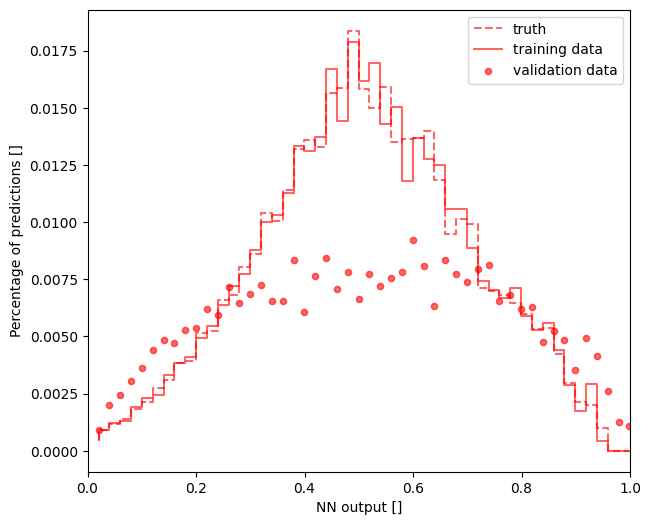

In [353]:
BINS=50

histograms_5 = generate_histograms_2(ratios_true[1]/(1 + ratios_true[1]), ratios_pred_train[1]/(1 + ratios_pred_train[1]), ratios_pred_val[1]/(1 + ratios_pred_val[1]), sample_train, sample_val, num_bins=BINS)

plot_histograms_2(histograms_5, color='red', xlim=(0,1), factor=0)

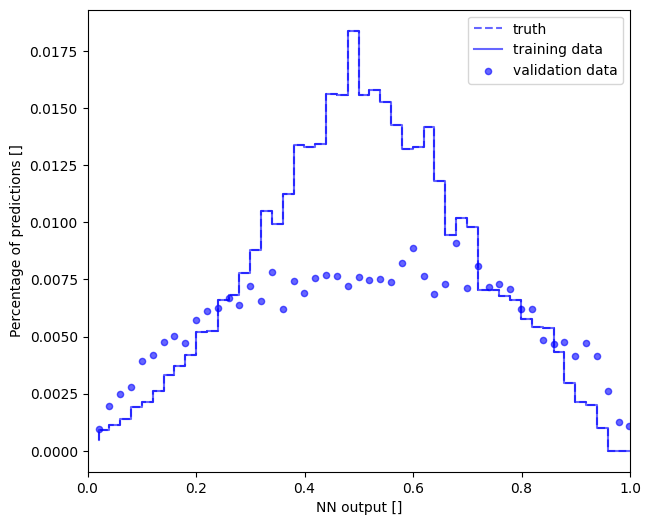

In [354]:
BINS=50

histograms_5 = generate_histograms_2(ratios_true[2]/(1 + ratios_true[2]), ratios_pred_train[2]/(1 + ratios_pred_train[2]), ratios_pred_val[2]/(1 + ratios_pred_val[2]), sample_train, sample_val, num_bins=BINS)

plot_histograms_2(histograms_5, color='blue', xlim=(0,1), factor=0)